# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

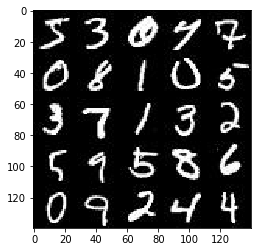

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

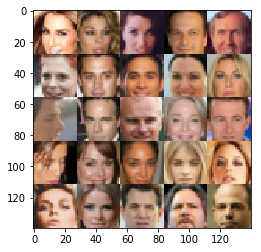

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        #1st layer, initializing with xavier glorot initializer
        logits = tf.layers.conv2d(images, 64, 5, strides=2, padding="SAME")
        logits = tf.maximum(alpha * logits, logits)
        #2nd layer
        logits = tf.layers.conv2d(logits, 128, 5, strides=2, padding="SAME")
        logits = tf.layers.batch_normalization(logits, training=True)
        logits = tf.maximum(alpha* logits,logits)
        #3rd layer
        logits = tf.layers.conv2d(logits, 256, 5, strides=2, padding="SAME")
        logits = tf.layers.batch_normalization(logits, training=True)
        logits = tf.maximum(alpha * logits, logits)
        #Flat layer
        logits = tf.reshape(logits, (-1, 4*4*256))
        logits = tf.layers.dense(logits, 1)
        out = tf.sigmoid(logits)

        return out, logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
#In discriminator block I coded every layer with a different variable, is easier to do in the same
#because you can stack similar layers copypasting it :) 
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        #1st connected layer
        logits = tf.layers.dense(z, 7*7*256)
        logits = tf.reshape(logits, (-1,7,7,256))
        logits = tf.layers.batch_normalization(logits,training=is_train)
        logits = tf.maximum(alpha * logits,logits)
        #2nd layer
        logits = tf.layers.conv2d_transpose(logits,128,5,strides=2,padding="SAME")
        logits = tf.layers.batch_normalization(logits, training=is_train)
        logits = tf.maximum(alpha * logits,logits)
        #3rd layer
        logits = tf.layers.conv2d_transpose(logits, 64, 5, strides=2, padding="SAME")
        logits = tf.layers.batch_normalization(logits, training=is_train)
        logits = tf.maximum(alpha * logits, logits)
        #4th layer
        logits = tf.layers.conv2d_transpose(logits, out_channel_dim, 5, strides=1, padding="SAME")
        #GAN-nmist lesson says tanh works better with generator function
        out = tf.tanh(logits) 
   
    return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model= generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    #For the labels, we want them to be all ones
    #label smoothing, typically used with classifiers to improve performance, smooth = 0.1
    d_loss_real= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    g_loss= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    d_loss= d_loss_real + d_loss_fake
    
    return d_loss,g_loss
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    #From gan-nmist lesson:
    # Get the trainable_variables, split into G and D parts
    t_vars= tf.trainable_variables()
    g_vars= [var for var in t_vars if var.name.startswith('generator')]
    d_vars= [var for var in t_vars if var.name.startswith('discriminator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import time
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #Extract shape from train function parameter
    images_count, image_width, image_height, image_channels = data_shape
    #Extract tensor placeholders from our function
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    print("We are starting to train... keep calm and lower the learning rate :)")
    starting_time = time.monotonic()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for idx,batch_images in enumerate(get_batches(batch_size)):
                #Range is now (-1,1)
                batch_images *= 2
                #Noise generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                if idx % 10 == 0:
                    #Print loss after 10 iterations
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    elapsed_time = time.monotonic() - starting_time
                    print("Epoch {}/{} ...".format(epoch_i+1, epoch_count),
                          "Discriminator loss: {:.4f} ...".format(train_loss_d),
                          "Generator loss: {:.4f} ... Time elapsed: ".format(train_loss_g),elapsed_time," seconds")
                #Print actual generated images after 100 iterations
                if idx % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

We are starting to train... keep calm and lower the learning rate :)
Epoch 1/2 ... Discriminator loss: 2.0759 ... Generator loss: 0.2226 ... Time elapsed:  6.422000000002299  seconds


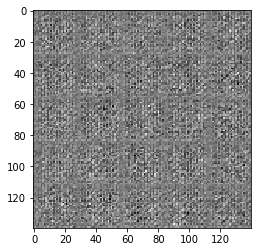

Epoch 1/2 ... Discriminator loss: 1.0823 ... Generator loss: 1.1111 ... Time elapsed:  8.7970000000023  seconds
Epoch 1/2 ... Discriminator loss: 2.0485 ... Generator loss: 0.7035 ... Time elapsed:  10.21900000000096  seconds
Epoch 1/2 ... Discriminator loss: 1.6805 ... Generator loss: 0.8214 ... Time elapsed:  11.639999999999418  seconds
Epoch 1/2 ... Discriminator loss: 1.5205 ... Generator loss: 1.1981 ... Time elapsed:  13.062000000001717  seconds
Epoch 1/2 ... Discriminator loss: 1.6293 ... Generator loss: 1.2385 ... Time elapsed:  14.484000000000378  seconds
Epoch 1/2 ... Discriminator loss: 1.3452 ... Generator loss: 0.9930 ... Time elapsed:  15.906000000002678  seconds
Epoch 1/2 ... Discriminator loss: 1.3625 ... Generator loss: 1.0618 ... Time elapsed:  17.312000000001717  seconds
Epoch 1/2 ... Discriminator loss: 1.6574 ... Generator loss: 1.1004 ... Time elapsed:  18.75  seconds
Epoch 1/2 ... Discriminator loss: 1.5778 ... Generator loss: 0.9215 ... Time elapsed:  20.1560000

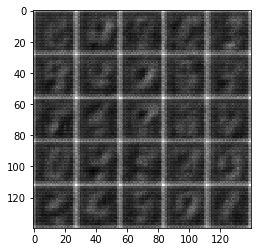

Epoch 1/2 ... Discriminator loss: 1.8214 ... Generator loss: 1.0055 ... Time elapsed:  23.95300000000134  seconds
Epoch 1/2 ... Discriminator loss: 1.6835 ... Generator loss: 0.9723 ... Time elapsed:  25.32800000000134  seconds
Epoch 1/2 ... Discriminator loss: 2.0904 ... Generator loss: 0.7506 ... Time elapsed:  26.73400000000038  seconds
Epoch 1/2 ... Discriminator loss: 1.6108 ... Generator loss: 0.8560 ... Time elapsed:  28.125  seconds
Epoch 1/2 ... Discriminator loss: 1.9789 ... Generator loss: 0.8109 ... Time elapsed:  29.562000000001717  seconds
Epoch 1/2 ... Discriminator loss: 1.7525 ... Generator loss: 0.8744 ... Time elapsed:  30.95300000000134  seconds
Epoch 1/2 ... Discriminator loss: 1.3424 ... Generator loss: 1.1706 ... Time elapsed:  32.35900000000038  seconds
Epoch 1/2 ... Discriminator loss: 2.1949 ... Generator loss: 0.9034 ... Time elapsed:  33.75  seconds
Epoch 1/2 ... Discriminator loss: 1.9838 ... Generator loss: 0.9887 ... Time elapsed:  35.13999999999942  seco

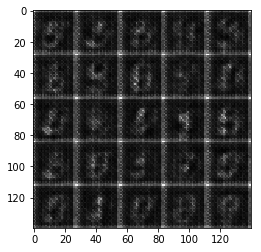

Epoch 1/2 ... Discriminator loss: 1.4752 ... Generator loss: 0.9267 ... Time elapsed:  39.18700000000172  seconds
Epoch 1/2 ... Discriminator loss: 1.7194 ... Generator loss: 0.8099 ... Time elapsed:  40.59400000000096  seconds
Epoch 1/2 ... Discriminator loss: 2.2705 ... Generator loss: 0.6627 ... Time elapsed:  41.96900000000096  seconds
Epoch 1/2 ... Discriminator loss: 1.9899 ... Generator loss: 0.6454 ... Time elapsed:  43.43700000000172  seconds
Epoch 1/2 ... Discriminator loss: 1.8536 ... Generator loss: 0.6952 ... Time elapsed:  44.85900000000038  seconds
Epoch 1/2 ... Discriminator loss: 1.6486 ... Generator loss: 0.8198 ... Time elapsed:  46.26499999999942  seconds
Epoch 1/2 ... Discriminator loss: 1.6777 ... Generator loss: 1.0450 ... Time elapsed:  47.75  seconds
Epoch 1/2 ... Discriminator loss: 1.5145 ... Generator loss: 0.8909 ... Time elapsed:  49.20300000000134  seconds
Epoch 1/2 ... Discriminator loss: 1.1825 ... Generator loss: 0.9888 ... Time elapsed:  50.5940000000

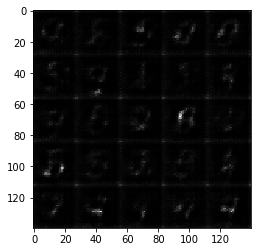

Epoch 1/2 ... Discriminator loss: 1.6566 ... Generator loss: 0.8924 ... Time elapsed:  54.40600000000268  seconds
Epoch 1/2 ... Discriminator loss: 1.5044 ... Generator loss: 0.9236 ... Time elapsed:  55.7970000000023  seconds
Epoch 1/2 ... Discriminator loss: 1.2758 ... Generator loss: 1.0967 ... Time elapsed:  57.23400000000038  seconds
Epoch 1/2 ... Discriminator loss: 1.2923 ... Generator loss: 0.9762 ... Time elapsed:  58.68700000000172  seconds
Epoch 1/2 ... Discriminator loss: 1.2462 ... Generator loss: 1.0848 ... Time elapsed:  60.13999999999942  seconds
Epoch 1/2 ... Discriminator loss: 1.2276 ... Generator loss: 1.0101 ... Time elapsed:  61.56200000000172  seconds
Epoch 1/2 ... Discriminator loss: 1.5907 ... Generator loss: 0.7392 ... Time elapsed:  63.01499999999942  seconds
Epoch 1/2 ... Discriminator loss: 1.3440 ... Generator loss: 0.9481 ... Time elapsed:  64.46900000000096  seconds
Epoch 1/2 ... Discriminator loss: 1.2646 ... Generator loss: 1.0838 ... Time elapsed:  65

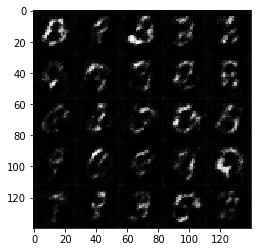

Epoch 1/2 ... Discriminator loss: 1.3670 ... Generator loss: 0.8937 ... Time elapsed:  69.70300000000134  seconds
Epoch 1/2 ... Discriminator loss: 1.4464 ... Generator loss: 1.0303 ... Time elapsed:  71.10900000000038  seconds
Epoch 1/2 ... Discriminator loss: 1.1157 ... Generator loss: 1.0659 ... Time elapsed:  72.51499999999942  seconds
Epoch 1/2 ... Discriminator loss: 1.1556 ... Generator loss: 1.1832 ... Time elapsed:  73.95300000000134  seconds
Epoch 1/2 ... Discriminator loss: 1.2016 ... Generator loss: 1.2463 ... Time elapsed:  75.375  seconds
Epoch 1/2 ... Discriminator loss: 1.1546 ... Generator loss: 1.0073 ... Time elapsed:  76.81200000000172  seconds
Epoch 2/2 ... Discriminator loss: 1.1766 ... Generator loss: 1.0653 ... Time elapsed:  77.98400000000038  seconds


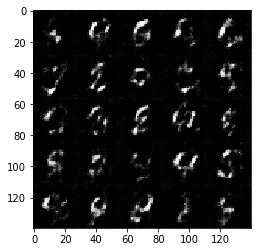

Epoch 2/2 ... Discriminator loss: 0.9939 ... Generator loss: 1.1819 ... Time elapsed:  80.375  seconds
Epoch 2/2 ... Discriminator loss: 0.9590 ... Generator loss: 1.2714 ... Time elapsed:  81.76499999999942  seconds
Epoch 2/2 ... Discriminator loss: 1.0281 ... Generator loss: 1.1424 ... Time elapsed:  83.15600000000268  seconds
Epoch 2/2 ... Discriminator loss: 1.2157 ... Generator loss: 1.0295 ... Time elapsed:  84.59400000000096  seconds
Epoch 2/2 ... Discriminator loss: 1.1256 ... Generator loss: 1.0406 ... Time elapsed:  86.01499999999942  seconds
Epoch 2/2 ... Discriminator loss: 0.9746 ... Generator loss: 1.3333 ... Time elapsed:  87.43700000000172  seconds
Epoch 2/2 ... Discriminator loss: 0.9672 ... Generator loss: 1.2991 ... Time elapsed:  88.82800000000134  seconds
Epoch 2/2 ... Discriminator loss: 1.0954 ... Generator loss: 1.0985 ... Time elapsed:  90.28100000000268  seconds
Epoch 2/2 ... Discriminator loss: 1.1108 ... Generator loss: 1.0653 ... Time elapsed:  91.703000000

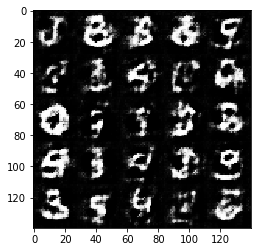

Epoch 2/2 ... Discriminator loss: 1.1045 ... Generator loss: 0.9817 ... Time elapsed:  95.45300000000134  seconds
Epoch 2/2 ... Discriminator loss: 1.0186 ... Generator loss: 1.1422 ... Time elapsed:  96.88999999999942  seconds
Epoch 2/2 ... Discriminator loss: 1.0552 ... Generator loss: 1.0473 ... Time elapsed:  98.2970000000023  seconds
Epoch 2/2 ... Discriminator loss: 0.9917 ... Generator loss: 1.1909 ... Time elapsed:  99.73400000000038  seconds
Epoch 2/2 ... Discriminator loss: 0.8609 ... Generator loss: 1.5260 ... Time elapsed:  101.18700000000172  seconds
Epoch 2/2 ... Discriminator loss: 0.9592 ... Generator loss: 1.3704 ... Time elapsed:  102.60900000000038  seconds
Epoch 2/2 ... Discriminator loss: 0.9969 ... Generator loss: 1.2370 ... Time elapsed:  104.03100000000268  seconds
Epoch 2/2 ... Discriminator loss: 1.0768 ... Generator loss: 1.2080 ... Time elapsed:  105.46900000000096  seconds
Epoch 2/2 ... Discriminator loss: 0.9399 ... Generator loss: 1.3270 ... Time elapsed:

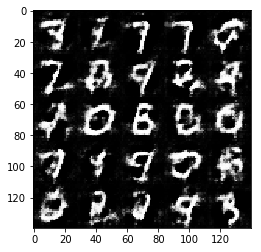

Epoch 2/2 ... Discriminator loss: 1.0225 ... Generator loss: 1.1332 ... Time elapsed:  110.70300000000134  seconds
Epoch 2/2 ... Discriminator loss: 0.9984 ... Generator loss: 1.4648 ... Time elapsed:  112.125  seconds
Epoch 2/2 ... Discriminator loss: 1.0672 ... Generator loss: 1.2366 ... Time elapsed:  113.60900000000038  seconds
Epoch 2/2 ... Discriminator loss: 1.0575 ... Generator loss: 1.2616 ... Time elapsed:  114.98400000000038  seconds
Epoch 2/2 ... Discriminator loss: 1.1304 ... Generator loss: 1.0003 ... Time elapsed:  116.43700000000172  seconds
Epoch 2/2 ... Discriminator loss: 1.0099 ... Generator loss: 1.3725 ... Time elapsed:  117.85900000000038  seconds
Epoch 2/2 ... Discriminator loss: 1.0117 ... Generator loss: 1.2056 ... Time elapsed:  119.31200000000172  seconds
Epoch 2/2 ... Discriminator loss: 1.0937 ... Generator loss: 1.1381 ... Time elapsed:  120.71900000000096  seconds
Epoch 2/2 ... Discriminator loss: 0.9419 ... Generator loss: 1.4124 ... Time elapsed:  122.

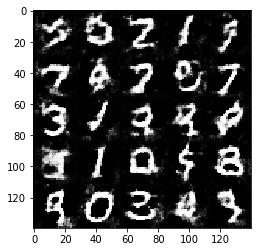

Epoch 2/2 ... Discriminator loss: 1.2185 ... Generator loss: 0.9678 ... Time elapsed:  126.03100000000268  seconds
Epoch 2/2 ... Discriminator loss: 1.0377 ... Generator loss: 1.1213 ... Time elapsed:  127.5  seconds
Epoch 2/2 ... Discriminator loss: 1.0885 ... Generator loss: 1.0721 ... Time elapsed:  128.9220000000023  seconds
Epoch 2/2 ... Discriminator loss: 1.1502 ... Generator loss: 1.0406 ... Time elapsed:  130.38999999999942  seconds
Epoch 2/2 ... Discriminator loss: 1.2320 ... Generator loss: 1.0443 ... Time elapsed:  131.81200000000172  seconds
Epoch 2/2 ... Discriminator loss: 1.0098 ... Generator loss: 1.2659 ... Time elapsed:  133.21900000000096  seconds
Epoch 2/2 ... Discriminator loss: 1.0217 ... Generator loss: 1.2134 ... Time elapsed:  134.68700000000172  seconds
Epoch 2/2 ... Discriminator loss: 1.1507 ... Generator loss: 0.9439 ... Time elapsed:  136.09400000000096  seconds
Epoch 2/2 ... Discriminator loss: 1.0935 ... Generator loss: 1.0929 ... Time elapsed:  137.514

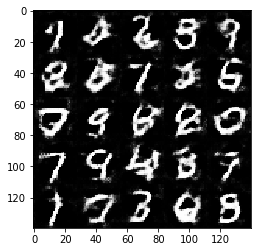

Epoch 2/2 ... Discriminator loss: 1.1991 ... Generator loss: 0.9379 ... Time elapsed:  141.63999999999942  seconds
Epoch 2/2 ... Discriminator loss: 1.2388 ... Generator loss: 1.1143 ... Time elapsed:  143.125  seconds
Epoch 2/2 ... Discriminator loss: 1.1493 ... Generator loss: 0.8662 ... Time elapsed:  144.53100000000268  seconds
Epoch 2/2 ... Discriminator loss: 1.2015 ... Generator loss: 1.8429 ... Time elapsed:  145.98400000000038  seconds
Epoch 2/2 ... Discriminator loss: 1.3730 ... Generator loss: 0.8163 ... Time elapsed:  147.4220000000023  seconds
Epoch 2/2 ... Discriminator loss: 1.2579 ... Generator loss: 0.9896 ... Time elapsed:  148.84400000000096  seconds


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

We are starting to train... keep calm and lower the learning rate :)
Epoch 1/1 ... Discriminator loss: 1.7836 ... Generator loss: 0.3705 ... Time elapsed:  4.484000000000378  seconds


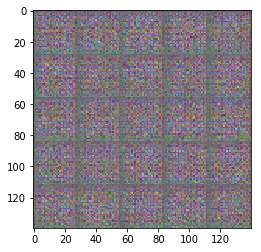

Epoch 1/1 ... Discriminator loss: 0.9267 ... Generator loss: 1.5359 ... Time elapsed:  8.484000000000378  seconds
Epoch 1/1 ... Discriminator loss: 0.7315 ... Generator loss: 1.5632 ... Time elapsed:  11.578000000001339  seconds
Epoch 1/1 ... Discriminator loss: 0.6654 ... Generator loss: 2.4594 ... Time elapsed:  14.65599999999904  seconds
Epoch 1/1 ... Discriminator loss: 0.8844 ... Generator loss: 1.8047 ... Time elapsed:  17.670999999998457  seconds
Epoch 1/1 ... Discriminator loss: 0.6598 ... Generator loss: 2.2941 ... Time elapsed:  20.75  seconds
Epoch 1/1 ... Discriminator loss: 0.9004 ... Generator loss: 1.4648 ... Time elapsed:  23.85900000000038  seconds
Epoch 1/1 ... Discriminator loss: 0.6907 ... Generator loss: 2.0220 ... Time elapsed:  27.0  seconds
Epoch 1/1 ... Discriminator loss: 0.8027 ... Generator loss: 2.0138 ... Time elapsed:  30.07800000000134  seconds
Epoch 1/1 ... Discriminator loss: 0.8133 ... Generator loss: 1.6792 ... Time elapsed:  33.21800000000076  secon

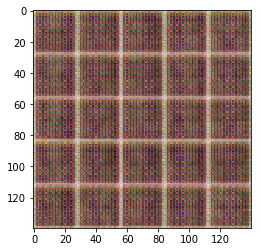

Epoch 1/1 ... Discriminator loss: 0.8251 ... Generator loss: 1.6726 ... Time elapsed:  40.81200000000172  seconds
Epoch 1/1 ... Discriminator loss: 0.9773 ... Generator loss: 1.2849 ... Time elapsed:  43.92099999999846  seconds
Epoch 1/1 ... Discriminator loss: 0.9738 ... Generator loss: 1.4268 ... Time elapsed:  47.23400000000038  seconds
Epoch 1/1 ... Discriminator loss: 1.1753 ... Generator loss: 1.4921 ... Time elapsed:  50.84300000000076  seconds
Epoch 1/1 ... Discriminator loss: 1.0453 ... Generator loss: 1.3742 ... Time elapsed:  54.46800000000076  seconds
Epoch 1/1 ... Discriminator loss: 0.9340 ... Generator loss: 1.6502 ... Time elapsed:  58.10900000000038  seconds
Epoch 1/1 ... Discriminator loss: 1.5792 ... Generator loss: 1.2293 ... Time elapsed:  61.82800000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.3906 ... Generator loss: 1.1502 ... Time elapsed:  65.45300000000134  seconds
Epoch 1/1 ... Discriminator loss: 0.9848 ... Generator loss: 1.5688 ... Time elapsed:  6

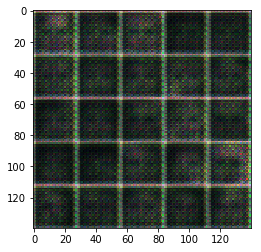

Epoch 1/1 ... Discriminator loss: 1.4154 ... Generator loss: 1.0273 ... Time elapsed:  77.32800000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.1572 ... Generator loss: 1.4607 ... Time elapsed:  80.93700000000172  seconds
Epoch 1/1 ... Discriminator loss: 1.0586 ... Generator loss: 1.6259 ... Time elapsed:  84.57800000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.3533 ... Generator loss: 1.3929 ... Time elapsed:  88.20300000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.0859 ... Generator loss: 1.2748 ... Time elapsed:  91.85900000000038  seconds
Epoch 1/1 ... Discriminator loss: 1.3633 ... Generator loss: 1.0205 ... Time elapsed:  95.43700000000172  seconds
Epoch 1/1 ... Discriminator loss: 1.4061 ... Generator loss: 1.0629 ... Time elapsed:  99.03099999999904  seconds
Epoch 1/1 ... Discriminator loss: 1.2011 ... Generator loss: 1.1847 ... Time elapsed:  102.625  seconds
Epoch 1/1 ... Discriminator loss: 1.2981 ... Generator loss: 1.2046 ... Time elapsed:  106.1709999

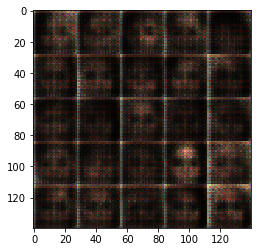

Epoch 1/1 ... Discriminator loss: 1.4485 ... Generator loss: 1.2585 ... Time elapsed:  114.35900000000038  seconds
Epoch 1/1 ... Discriminator loss: 1.3487 ... Generator loss: 0.9299 ... Time elapsed:  117.98400000000038  seconds
Epoch 1/1 ... Discriminator loss: 1.1498 ... Generator loss: 1.1611 ... Time elapsed:  121.57800000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.1910 ... Generator loss: 1.3511 ... Time elapsed:  125.31200000000172  seconds
Epoch 1/1 ... Discriminator loss: 1.2757 ... Generator loss: 0.9872 ... Time elapsed:  128.88999999999942  seconds
Epoch 1/1 ... Discriminator loss: 1.0962 ... Generator loss: 0.9660 ... Time elapsed:  132.57800000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.1887 ... Generator loss: 0.9083 ... Time elapsed:  136.17099999999846  seconds
Epoch 1/1 ... Discriminator loss: 1.2760 ... Generator loss: 0.8794 ... Time elapsed:  139.76499999999942  seconds
Epoch 1/1 ... Discriminator loss: 0.7081 ... Generator loss: 1.9097 ... Time ela

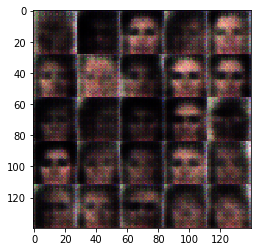

Epoch 1/1 ... Discriminator loss: 0.9232 ... Generator loss: 2.3072 ... Time elapsed:  151.59300000000076  seconds
Epoch 1/1 ... Discriminator loss: 0.9004 ... Generator loss: 1.7867 ... Time elapsed:  155.21800000000076  seconds
Epoch 1/1 ... Discriminator loss: 1.3378 ... Generator loss: 1.7381 ... Time elapsed:  158.81200000000172  seconds
Epoch 1/1 ... Discriminator loss: 0.9940 ... Generator loss: 1.4056 ... Time elapsed:  162.43700000000172  seconds
Epoch 1/1 ... Discriminator loss: 1.0601 ... Generator loss: 1.4246 ... Time elapsed:  166.07800000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.4363 ... Generator loss: 1.8219 ... Time elapsed:  169.68700000000172  seconds
Epoch 1/1 ... Discriminator loss: 1.2124 ... Generator loss: 1.3277 ... Time elapsed:  173.26499999999942  seconds
Epoch 1/1 ... Discriminator loss: 1.0798 ... Generator loss: 1.5049 ... Time elapsed:  176.88999999999942  seconds
Epoch 1/1 ... Discriminator loss: 1.0641 ... Generator loss: 1.2787 ... Time ela

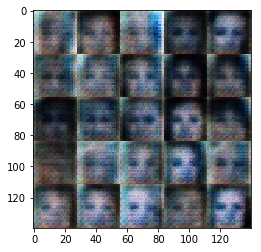

Epoch 1/1 ... Discriminator loss: 1.0796 ... Generator loss: 1.3143 ... Time elapsed:  188.875  seconds
Epoch 1/1 ... Discriminator loss: 1.7192 ... Generator loss: 0.7656 ... Time elapsed:  192.51499999999942  seconds
Epoch 1/1 ... Discriminator loss: 1.5851 ... Generator loss: 0.8623 ... Time elapsed:  196.15599999999904  seconds
Epoch 1/1 ... Discriminator loss: 1.1982 ... Generator loss: 1.7096 ... Time elapsed:  199.79599999999846  seconds
Epoch 1/1 ... Discriminator loss: 1.2840 ... Generator loss: 1.0665 ... Time elapsed:  203.46800000000076  seconds
Epoch 1/1 ... Discriminator loss: 1.1056 ... Generator loss: 1.1543 ... Time elapsed:  207.20300000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.2609 ... Generator loss: 1.1064 ... Time elapsed:  210.85900000000038  seconds
Epoch 1/1 ... Discriminator loss: 1.5233 ... Generator loss: 0.8399 ... Time elapsed:  214.45300000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.7938 ... Generator loss: 0.8138 ... Time elapsed:  218.

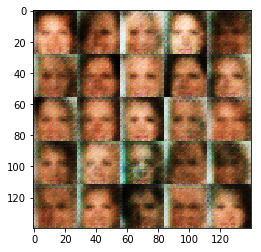

Epoch 1/1 ... Discriminator loss: 1.1022 ... Generator loss: 1.3878 ... Time elapsed:  226.28099999999904  seconds
Epoch 1/1 ... Discriminator loss: 1.3637 ... Generator loss: 1.1571 ... Time elapsed:  229.875  seconds
Epoch 1/1 ... Discriminator loss: 1.3714 ... Generator loss: 0.9707 ... Time elapsed:  233.48400000000038  seconds
Epoch 1/1 ... Discriminator loss: 1.1698 ... Generator loss: 1.1085 ... Time elapsed:  237.07800000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.3636 ... Generator loss: 1.2189 ... Time elapsed:  240.73400000000038  seconds
Epoch 1/1 ... Discriminator loss: 1.1593 ... Generator loss: 0.8045 ... Time elapsed:  244.32800000000134  seconds
Epoch 1/1 ... Discriminator loss: 2.2010 ... Generator loss: 0.9271 ... Time elapsed:  247.92099999999846  seconds
Epoch 1/1 ... Discriminator loss: 1.3831 ... Generator loss: 0.7748 ... Time elapsed:  251.54599999999846  seconds
Epoch 1/1 ... Discriminator loss: 1.3991 ... Generator loss: 1.1876 ... Time elapsed:  255.

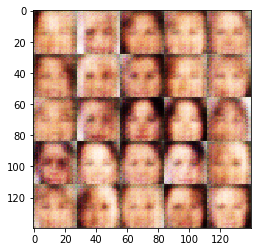

Epoch 1/1 ... Discriminator loss: 1.1092 ... Generator loss: 1.1884 ... Time elapsed:  263.45300000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.3308 ... Generator loss: 1.0498 ... Time elapsed:  267.04599999999846  seconds
Epoch 1/1 ... Discriminator loss: 1.3191 ... Generator loss: 1.0645 ... Time elapsed:  270.6870000000017  seconds
Epoch 1/1 ... Discriminator loss: 1.3943 ... Generator loss: 0.9015 ... Time elapsed:  274.28099999999904  seconds
Epoch 1/1 ... Discriminator loss: 1.1336 ... Generator loss: 1.1499 ... Time elapsed:  277.9370000000017  seconds
Epoch 1/1 ... Discriminator loss: 1.0031 ... Generator loss: 1.3173 ... Time elapsed:  281.46800000000076  seconds
Epoch 1/1 ... Discriminator loss: 1.1223 ... Generator loss: 1.1191 ... Time elapsed:  285.1090000000004  seconds
Epoch 1/1 ... Discriminator loss: 1.0644 ... Generator loss: 1.1694 ... Time elapsed:  288.71800000000076  seconds
Epoch 1/1 ... Discriminator loss: 1.1056 ... Generator loss: 1.1550 ... Time elapse

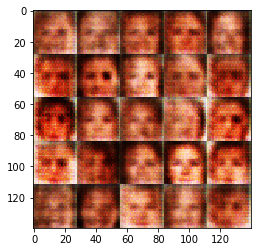

Epoch 1/1 ... Discriminator loss: 1.4251 ... Generator loss: 0.6848 ... Time elapsed:  303.0620000000017  seconds
Epoch 1/1 ... Discriminator loss: 1.3767 ... Generator loss: 1.0882 ... Time elapsed:  307.0149999999994  seconds
Epoch 1/1 ... Discriminator loss: 1.0389 ... Generator loss: 1.4951 ... Time elapsed:  311.3590000000004  seconds
Epoch 1/1 ... Discriminator loss: 1.2344 ... Generator loss: 1.1655 ... Time elapsed:  315.65599999999904  seconds
Epoch 1/1 ... Discriminator loss: 1.3045 ... Generator loss: 0.9996 ... Time elapsed:  319.92099999999846  seconds
Epoch 1/1 ... Discriminator loss: 1.1612 ... Generator loss: 0.9009 ... Time elapsed:  323.96800000000076  seconds
Epoch 1/1 ... Discriminator loss: 1.2734 ... Generator loss: 0.7499 ... Time elapsed:  327.92099999999846  seconds
Epoch 1/1 ... Discriminator loss: 1.2529 ... Generator loss: 0.8838 ... Time elapsed:  332.04599999999846  seconds
Epoch 1/1 ... Discriminator loss: 1.2058 ... Generator loss: 1.2042 ... Time elapse

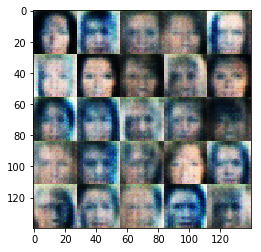

Epoch 1/1 ... Discriminator loss: 1.1385 ... Generator loss: 1.1631 ... Time elapsed:  345.1399999999994  seconds
Epoch 1/1 ... Discriminator loss: 0.9427 ... Generator loss: 1.4794 ... Time elapsed:  349.07800000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.4546 ... Generator loss: 0.9980 ... Time elapsed:  352.9840000000004  seconds
Epoch 1/1 ... Discriminator loss: 1.5228 ... Generator loss: 0.8503 ... Time elapsed:  356.92099999999846  seconds
Epoch 1/1 ... Discriminator loss: 1.3655 ... Generator loss: 1.0997 ... Time elapsed:  360.875  seconds
Epoch 1/1 ... Discriminator loss: 1.1055 ... Generator loss: 1.3501 ... Time elapsed:  364.8590000000004  seconds
Epoch 1/1 ... Discriminator loss: 1.2484 ... Generator loss: 1.1317 ... Time elapsed:  368.78099999999904  seconds
Epoch 1/1 ... Discriminator loss: 1.2066 ... Generator loss: 1.2144 ... Time elapsed:  372.79599999999846  seconds
Epoch 1/1 ... Discriminator loss: 1.2380 ... Generator loss: 1.1681 ... Time elapsed:  376.734

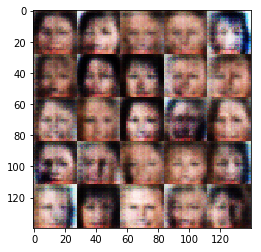

Epoch 1/1 ... Discriminator loss: 1.4147 ... Generator loss: 0.8633 ... Time elapsed:  385.7340000000004  seconds
Epoch 1/1 ... Discriminator loss: 1.3289 ... Generator loss: 1.0973 ... Time elapsed:  389.67099999999846  seconds
Epoch 1/1 ... Discriminator loss: 0.9542 ... Generator loss: 1.5500 ... Time elapsed:  393.625  seconds
Epoch 1/1 ... Discriminator loss: 1.3992 ... Generator loss: 1.0482 ... Time elapsed:  397.54599999999846  seconds
Epoch 1/1 ... Discriminator loss: 1.1013 ... Generator loss: 1.2586 ... Time elapsed:  401.5  seconds
Epoch 1/1 ... Discriminator loss: 1.0791 ... Generator loss: 1.4100 ... Time elapsed:  405.42099999999846  seconds
Epoch 1/1 ... Discriminator loss: 1.2884 ... Generator loss: 1.1737 ... Time elapsed:  409.34300000000076  seconds
Epoch 1/1 ... Discriminator loss: 1.3437 ... Generator loss: 0.7963 ... Time elapsed:  413.29599999999846  seconds
Epoch 1/1 ... Discriminator loss: 1.1450 ... Generator loss: 0.9920 ... Time elapsed:  417.21800000000076

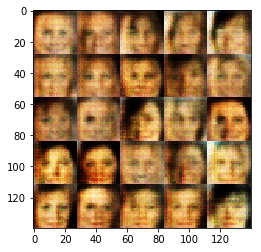

Epoch 1/1 ... Discriminator loss: 1.7187 ... Generator loss: 0.7246 ... Time elapsed:  426.32800000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.5227 ... Generator loss: 0.7544 ... Time elapsed:  430.46800000000076  seconds
Epoch 1/1 ... Discriminator loss: 1.4589 ... Generator loss: 0.9359 ... Time elapsed:  434.625  seconds
Epoch 1/1 ... Discriminator loss: 1.2721 ... Generator loss: 1.0846 ... Time elapsed:  438.57800000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.3547 ... Generator loss: 0.9710 ... Time elapsed:  442.5620000000017  seconds
Epoch 1/1 ... Discriminator loss: 1.2589 ... Generator loss: 0.8505 ... Time elapsed:  446.625  seconds
Epoch 1/1 ... Discriminator loss: 1.4430 ... Generator loss: 0.9510 ... Time elapsed:  450.7649999999994  seconds
Epoch 1/1 ... Discriminator loss: 1.6351 ... Generator loss: 0.9533 ... Time elapsed:  454.8120000000017  seconds
Epoch 1/1 ... Discriminator loss: 2.0000 ... Generator loss: 0.8270 ... Time elapsed:  458.78099999999904

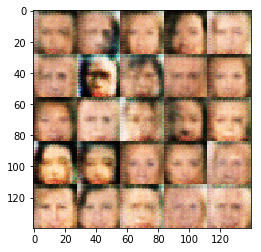

Epoch 1/1 ... Discriminator loss: 1.5732 ... Generator loss: 0.9860 ... Time elapsed:  467.9840000000004  seconds
Epoch 1/1 ... Discriminator loss: 1.3083 ... Generator loss: 0.9454 ... Time elapsed:  471.9840000000004  seconds
Epoch 1/1 ... Discriminator loss: 1.4495 ... Generator loss: 0.8756 ... Time elapsed:  475.95300000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.6784 ... Generator loss: 0.8784 ... Time elapsed:  479.95300000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.4999 ... Generator loss: 1.0425 ... Time elapsed:  483.9370000000017  seconds
Epoch 1/1 ... Discriminator loss: 1.3767 ... Generator loss: 0.9141 ... Time elapsed:  487.9370000000017  seconds
Epoch 1/1 ... Discriminator loss: 1.1723 ... Generator loss: 1.0544 ... Time elapsed:  491.9840000000004  seconds
Epoch 1/1 ... Discriminator loss: 1.1466 ... Generator loss: 1.0203 ... Time elapsed:  495.9840000000004  seconds
Epoch 1/1 ... Discriminator loss: 1.3548 ... Generator loss: 1.0431 ... Time elapsed: 

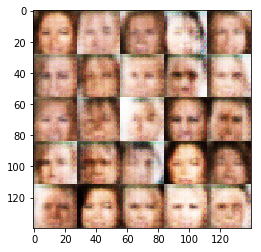

Epoch 1/1 ... Discriminator loss: 1.6122 ... Generator loss: 0.8478 ... Time elapsed:  509.70300000000134  seconds
Epoch 1/1 ... Discriminator loss: 1.5101 ... Generator loss: 0.9459 ... Time elapsed:  513.780999999999  seconds
Epoch 1/1 ... Discriminator loss: 1.3642 ... Generator loss: 1.0481 ... Time elapsed:  517.7959999999985  seconds
Epoch 1/1 ... Discriminator loss: 1.2287 ... Generator loss: 1.0606 ... Time elapsed:  521.8280000000013  seconds
Epoch 1/1 ... Discriminator loss: 1.4173 ... Generator loss: 0.9071 ... Time elapsed:  525.875  seconds
Epoch 1/1 ... Discriminator loss: 1.4264 ... Generator loss: 0.8990 ... Time elapsed:  529.9209999999985  seconds
Epoch 1/1 ... Discriminator loss: 1.1949 ... Generator loss: 1.0345 ... Time elapsed:  533.9370000000017  seconds
Epoch 1/1 ... Discriminator loss: 1.2377 ... Generator loss: 0.9941 ... Time elapsed:  538.0  seconds
Epoch 1/1 ... Discriminator loss: 1.3728 ... Generator loss: 0.9479 ... Time elapsed:  542.0149999999994  seco

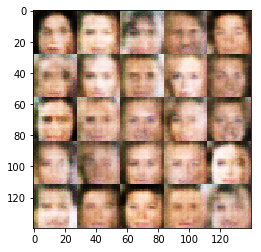

Epoch 1/1 ... Discriminator loss: 1.5263 ... Generator loss: 0.9044 ... Time elapsed:  551.2030000000013  seconds
Epoch 1/1 ... Discriminator loss: 1.2579 ... Generator loss: 1.0701 ... Time elapsed:  555.2959999999985  seconds
Epoch 1/1 ... Discriminator loss: 1.2054 ... Generator loss: 1.0162 ... Time elapsed:  559.405999999999  seconds
Epoch 1/1 ... Discriminator loss: 1.3629 ... Generator loss: 1.0503 ... Time elapsed:  563.530999999999  seconds
Epoch 1/1 ... Discriminator loss: 1.3931 ... Generator loss: 0.9372 ... Time elapsed:  567.625  seconds
Epoch 1/1 ... Discriminator loss: 1.2444 ... Generator loss: 0.9499 ... Time elapsed:  571.7340000000004  seconds
Epoch 1/1 ... Discriminator loss: 1.1586 ... Generator loss: 1.1089 ... Time elapsed:  575.780999999999  seconds
Epoch 1/1 ... Discriminator loss: 1.3473 ... Generator loss: 1.1094 ... Time elapsed:  579.875  seconds
Epoch 1/1 ... Discriminator loss: 1.3786 ... Generator loss: 0.8996 ... Time elapsed:  583.9680000000008  secon

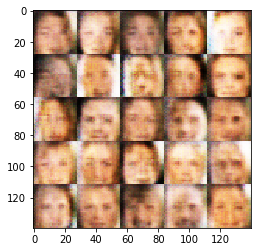

Epoch 1/1 ... Discriminator loss: 1.2746 ... Generator loss: 0.9518 ... Time elapsed:  593.2649999999994  seconds
Epoch 1/1 ... Discriminator loss: 1.2035 ... Generator loss: 1.1410 ... Time elapsed:  597.2959999999985  seconds
Epoch 1/1 ... Discriminator loss: 1.3096 ... Generator loss: 0.9509 ... Time elapsed:  601.375  seconds
Epoch 1/1 ... Discriminator loss: 1.4154 ... Generator loss: 1.0489 ... Time elapsed:  605.4209999999985  seconds
Epoch 1/1 ... Discriminator loss: 1.4170 ... Generator loss: 0.8812 ... Time elapsed:  609.4840000000004  seconds
Epoch 1/1 ... Discriminator loss: 1.4380 ... Generator loss: 0.9522 ... Time elapsed:  613.6090000000004  seconds
Epoch 1/1 ... Discriminator loss: 1.3644 ... Generator loss: 1.0030 ... Time elapsed:  617.655999999999  seconds
Epoch 1/1 ... Discriminator loss: 1.3124 ... Generator loss: 0.9555 ... Time elapsed:  621.75  seconds


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.00007
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.